# Week 5 - AB Testing

Google Analytics provides APIs for others to retrieve data in a flexible way. The flexible report generation is based on the definition of **dimensions** and **metrics**.
More information about dimensions and metrics can be found [here](https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema). More information about how to generate reports can be found [here](https://developers.google.com/analytics/devguides/reporting/data/v1/basics#python_3).

# 1. Import Packages

In [6]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,
    Metric,
    RunReportRequest,
    Filter,
    FilterExpression,
)
import os
import pandas as pd
import json

# 2 Report Generation
Below is a function ```sample_run_report```. The parameter is the property id, and the dimensions, metrics, and date_ranges can be specified below.

## 2.1 Conversion Report
The report below collects collects event sessions by experimental group

In [1]:
def sample_run_report_conversion(property_id="424145747"):
    """Runs a simple report on a Google Analytics 4 property."""
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'apt-port-251804-905e08b9e9e3.json'
    client = BetaAnalyticsDataClient()
    request = RunReportRequest(
        property="properties/{}".format(property_id),
        dimensions=[Dimension(name="campaignName"),Dimension(name="eventName"),Dimension(name="date")], #Dimension(name="sessionCampaignName"),
        metrics=[Metric(name="sessions")],
        date_ranges=[DateRange(start_date="2024-01-01", end_date="today")],
         dimension_filter=FilterExpression(
            filter=Filter(
                field_name="campaignName",
                in_list_filter=Filter.InListFilter(
                    values=[
                        "main",
                        "experiment"
                    ]
                ),
            )
        ),
    )
    response = client.run_report(request)
    return response

## 2.2 Session Report
The report below shows all experimental sessions:

In [2]:
def sample_run_report_session(property_id="424145747"):
    """Runs a simple report on a Google Analytics 4 property."""
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'apt-port-251804-905e08b9e9e3.json'
    client = BetaAnalyticsDataClient()
    request = RunReportRequest(
        property="properties/{}".format(property_id),
        dimensions=[Dimension(name="customEvent:Branch"),Dimension(name="date")], #Dimension(name="sessionCampaignName"),
        metrics=[Metric(name="sessions")],
        date_ranges=[DateRange(start_date="2024-01-01", end_date="today")],
          dimension_filter=FilterExpression(
            filter=Filter(
                field_name="customEvent:Branch",
                in_list_filter=Filter.InListFilter(
                    values=[
                        "main",
                        "experiment"
                    ]
                ),
            )
        ),
    )
    response = client.run_report(request)
    return response

# 3 Data Conversion
The default output is json, which we can transform into a dataframe using the following function **response_to_df**.

In [7]:
def response_to_df(response):
    columns = []
    rows = []
     
    for col in response.dimension_headers:
        columns.append(col.name)
    for col in response.metric_headers:
        columns.append(col.name)
     
    for row_data in response.rows:
        row = []
        for val in row_data.dimension_values:
            row.append(val.value)
        for val in row_data.metric_values:
            row.append(val.value)
        rows.append(row)
    return pd.DataFrame(rows, columns=columns)


# 4 Data Collection Pipeline

## 4.1 Conversion Data
The code below shows the main pipeline of this task.

In [8]:
response=sample_run_report_conversion(property_id="424145747")
df1=response_to_df(response)
print(df1)

# change the column name from  campaignName to customEvent:Branch
df1.rename(columns={'campaignName': 'customEvent:Branch'}, inplace=True)
# Only look at submit
df1 = df1[df1['eventName'] == 'submit']

   campaignName eventName      date sessions
0    experiment    submit  20240311        6
1    experiment     again  20240311        4
2    experiment    submit  20240305        3
3          main    submit  20240322        3
4    experiment     again  20240305        2
5    experiment    submit  20240309        2
6    experiment    submit  20240310        2
7    experiment    submit  20240322        2
8          main     again  20240305        2
9          main    submit  20240305        2
10   experiment     again  20240309        1
11         main     again  20240309        1
12         main    submit  20240309        1


## 4.2 Session Data

In [9]:
response=sample_run_report_session(property_id="424145747")
df2=response_to_df(response)
print(df2)

   customEvent:Branch      date sessions
0                main  20240318       20
1          experiment  20240311       14
2                main  20240311       12
3          experiment  20240305        6
4                main  20240322        6
5                main  20240305        5
6          experiment  20240310        4
7                main  20240312        4
8                main  20240313        4
9                main  20240401        4
10               main  20240304        3
11               main  20240323        3
12               main  20240324        3
13               main  20240328        3
14         experiment  20240304        2
15         experiment  20240306        2
16         experiment  20240309        2
17         experiment  20240312        2
18               main  20240306        2
19               main  20240310        2
20               main  20240316        2
21               main  20240317        2
22               main  20240319        2
23              

# 5. Hypothesis Testing 

## 5.1 Prepare Data
To combine the two datasets, we used a merge function:

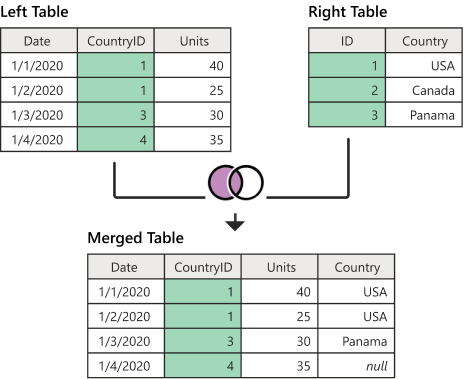

In [11]:
from scipy import stats
import numpy as np

# the merge function can combine two dataframes based on keywords. A left 
merged_df = pd.merge(df2, df1, on=['date', 'customEvent:Branch'], how='left')

merged_df.fillna(0, inplace=True)

# calculate the ratio between submission sessions and all sessions per day.
merged_df['submit_session_ratio_per_day']=merged_df['sessions_y'].astype(int)/merged_df['sessions_x'].astype(int)

# extract data for control
control = merged_df[merged_df['customEvent:Branch'] == 'main']['submit_session_ratio_per_day']
# extract data for treatment 
treatment =merged_df[merged_df['customEvent:Branch'] == 'experiment']['submit_session_ratio_per_day']

n_control=len(control)
n_treatment=len(treatment)

# Calculate sample means for both groups
mean_control = np.mean(control)
mean_treatment = np.mean(treatment)

# Calculate sample variance for both groups
var_control = np.var(control)
var_treatment = np.var(treatment)
t_stat, p_value = stats.ttest_ind(treatment, control)
# Define significance level
alpha = 0.05
confidence_level=1-alpha
relative_difference = (mean_treatment - mean_control) / mean_control
se_relative_difference = np.sqrt((var_control / n_control + var_treatment / n_treatment) / mean_control**2)
z_critical = stats.norm.ppf((1 + confidence_level) / 2)
lower_bound = relative_difference - z_critical * se_relative_difference
upper_bound = relative_difference + z_critical * se_relative_difference

# Check if the difference is statistically significant
if p_value < alpha:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

# Output the results
print(f"Control Group Mean: {mean_control}")
print(f"Treatment Group Mean: {mean_treatment}")
print(f"P-Value: {p_value}")
print(f"Relative Difference: {relative_difference}")
print(f"Lower Bound for Difference: {lower_bound}")
print(f"Upper Bound for Difference: {upper_bound}")

The difference is statistically significant.
Control Group Mean: 0.07307692307692307
Treatment Group Mean: 0.34693877551020413
P-Value: 0.01949426210778139
Relative Difference: 3.747583243823847
Lower Bound for Difference: 0.04616409698665924
Upper Bound for Difference: 7.449002390661034


# Practice
Compare the session numbers for the two campaigns: one with medium being "announcement" and the other with medium being "canvas".

In [83]:
# Practice
def sample_run_report_practice(property_id="424145747"):
    """Runs a simple report on a Google Analytics 4 property."""
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'apt-port-251804-905e08b9e9e3.json'
    client = BetaAnalyticsDataClient()
    request = RunReportRequest(
        property="properties/{}".format(property_id),
        dimensions=[Dimension(name="source"),Dimension(name="medium"),Dimension(name="date")], #Dimension(name="sessionCampaignName"),
        metrics=[Metric(name="sessions")],
        date_ranges=[DateRange(start_date="2024-01-01", end_date="today")],
         dimension_filter=FilterExpression(
            filter=Filter(
                field_name="source",
                in_list_filter=Filter.InListFilter(
                    values=[
                        "social"
                    ]
                ),
            )
        ),
    )
    response = client.run_report(request)
    return response

In [87]:
response=sample_run_report_practice(property_id="424145747")
df=response_to_df(response)
print(df)

   source        medium      date sessions
0  social        canvas  20240311        3
1  social  announcement  20240310        2
2  social        canvas  20240309        2
3  social  announcement  20240309        1
4  social  announcement  20240311        1
5  social  announcement  20240322        1
6  social        canvas  20240322        1


In [90]:
# Hypothesis testing

control = df[df['medium'] == 'canvas']['sessions'].astype(int)
# extract data for treatment 
treatment =df[df['medium'] == 'announcement']['sessions'].astype(int)


mean_control = #complete the code
mean_treatment = #complete the code

# Calculate sample standard deviations for both groups
std_control = #complete the code
std_treatment = #complete the code


t_stat, p_value = stats.ttest_ind(
    #complete the code
    )

# Define significance level
alpha = 0.05

# Check if the difference is statistically significant
if p_value < alpha:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

# Output the results
print(f"Control Group Mean: {mean_control}")
print(f"Treatment Group Mean: {mean_treatment}")
print(f"P-Value: {p_value}")

The difference is not statistically significant.
Control Group Mean: 2.0
Treatment Group Mean: 1.25
P-Value: 0.2427680009919807
